* RFM用户分层（分位数）
* 根据地区划分支付方式

RFM分层

In [74]:
import pandas as pd
pd.options.display.max_columns=46

In [75]:
import pickle
with open('eda.pkl', 'rb') as f:
    data = pickle.load(f)

用户分层，对象：用户 custoum_id
* R Recency           order date
* F Frequency         groupby .count()
* M Money             Order Item Product Price


In [76]:
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,Customer Segment,Customer State,Customer Street,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Order Item Discount,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Sales,Order Profit Per Order,Order Region,Order State,Order Status,Product Name,Product Price,shipping date (DateOrders),Shipping Mode,Customer FullName,order_year,order_month,order_week_day,order_hour,order_month_year
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,Cally,20755,Holloway,Consumer,PR,5365 Noble Nectar Island,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,2018-01-31 22:56:00,77202,13.110000,0.04,0.29,1,327.75,91.250000,Southeast Asia,Java Occidental,COMPLETE,Smart watch,327.75,2018-02-03 22:56:00,Standard Class,CallyHolloway,2018,1,2,22,2018-01
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,Irene,19492,Luna,Consumer,PR,2679 Rustic Loop,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,2018-01-13 12:27:00,75939,16.389999,0.05,-0.80,1,327.75,-249.089996,South Asia,Rajastán,PENDING,Smart watch,327.75,2018-01-18 12:27:00,Standard Class,IreneLuna,2018,1,5,12,2018-01
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,Gillian,19491,Maldonado,Consumer,CA,8510 Round Bear Gate,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,2018-01-13 12:06:00,75938,18.030001,0.06,-0.80,1,327.75,-247.779999,South Asia,Rajastán,CLOSED,Smart watch,327.75,2018-01-17 12:06:00,Standard Class,GillianMaldonado,2018,1,5,12,2018-01
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,Tana,19490,Tate,Home Office,CA,3200 Amber Bend,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,2018-01-13 11:45:00,75937,22.940001,0.07,0.08,1,327.75,22.860001,Oceania,Queensland,COMPLETE,Smart watch,327.75,2018-01-16 11:45:00,Standard Class,TanaTate,2018,1,5,11,2018-01
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,Orli,19489,Hendricks,Corporate,PR,8671 Iron Anchor Corners,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,2018-01-13 11:24:00,75936,29.500000,0.09,0.45,1,327.75,134.210007,Oceania,Queensland,PENDING_PAYMENT,Smart watch,327.75,2018-01-15 11:24:00,Standard Class,OrliHendricks,2018,1,5,11,2018-01


data['order date (DateOrders)'].max()为整个数据的最后一笔订单，因此R recency计算的是基于这个时间的近期。

In [77]:
temp = pd.DatetimeIndex(data['order date (DateOrders)'])

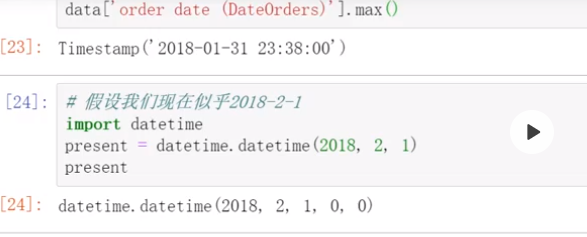

#### 确定现在的时间

In [78]:
import datetime
present = datetime.datetime(2018,2,1)
present

datetime.datetime(2018, 2, 1, 0, 0)

In [83]:
data['R_Value'] = (present-temp).days
data['R_Value']

0           0
1          18
2          18
3          18
4          18
         ... 
180514    746
180515    746
180516    747
180517    747
180518    747
Name: R_Value, Length: 180519, dtype: int64

RFM

In [84]:
customer_seg = data.groupby('Customer Id').agg({'R_Value': lambda x:x.min(),
                                                 'Order Id': lambda x:len(x),
                                                 'Sales': lambda x:x.sum()})
customer_seg

,R_Value,Order Id,Sales
Customer Id,,,
1,792,1,499.950012
2,136,10,1819.730034
3,229,18,3537.680094
4,380,14,1719.630030
5,457,7,1274.750023
...,...,...,...
20753,0,1,215.820007
20754,0,1,215.820007
20755,0,1,327.750000


In [85]:
customer_seg.rename(columns={'Order Id':'F_Value',
                      'Sales': 'M_Value'},inplace=True)

In [86]:
customer_seg

,R_Value,F_Value,M_Value
Customer Id,,,
1,792,1,499.950012
2,136,10,1819.730034
3,229,18,3537.680094
4,380,14,1719.630030
5,457,7,1274.750023
...,...,...,...
20753,0,1,215.820007
20754,0,1,215.820007
20755,0,1,327.750000


为什么要分桶，你看1123天没来买东西的人和772天没来买的人有区别吗？几乎没有吧，那就不需要区别对待，我感觉可以四分位，然后再对重要的位置四分位，就是后面的不影响，就不用细分，前面的可以按周分，一周 两周 三周 接着两个月 半年 一年等等

#### 求分位数

In [87]:
quantiles = customer_seg.quantile(q=[0.25,0.5,0.75])
quantiles

,R_Value,F_Value,M_Value
0.25,75.0,1.0,293.040008
0.50,159.0,7.0,1499.825033
0.75,307.0,15.0,2915.880065


In [88]:
quantiles = quantiles.to_dict()
quantiles

{'R_Value': {0.25: 75.0, 0.5: 159.0, 0.75: 307.0},
 'F_Value': {0.25: 1.0, 0.5: 7.0, 0.75: 15.0},
 'M_Value': {0.25: 293.0400085, 0.5: 1499.82503324, 0.75: 2915.8800654175}}

In [89]:
# Recency 越小越好！！！，返回数值越高
def R_Score(data, b, quantile):
    '''b为quantitle中的key'''
    if data <= quantile[b][0.25]:
        return 4
    if (data > quantile[b][0.25]) & (data <= quantile[b][0.5]):
        return 3
    if (data > quantile[b][0.5]) & (data <= quantile[b][0.75]):
        return 2
    if (data > quantile[b][0.75]):
        return 1
    
def FM_Score(data, b, quantile):
    if data <= quantile[b][0.25]:
        return 1
    if (data > quantile[b][0.25]) & (data <= quantile[b][0.5]):
        return 2
    if (data > quantile[b][0.5]) & (data <= quantile[b][0.75]):
        return 3
    if (data > quantile[b][0.75]):
        return 4

In [90]:
customer_seg.columns

Index(['R_Value', 'F_Value', 'M_Value'], dtype='object')

In [91]:
customer_seg['R_Score'] = customer_seg['R_Value'].apply(R_Score, args=('R_Value', quantiles))
customer_seg['F_Score'] = customer_seg['F_Value'].apply(FM_Score, args=('F_Value', quantiles))
customer_seg['M_Score'] = customer_seg['M_Value'].apply(FM_Score, args=('M_Value', quantiles))

In [92]:
def customer_label(data):
    # 虽然每个层面分了四级1234，但画图方便的话，就分高低嘛，12为低，34为高，RFM共8个象限
    if (data['R_Score'] > 2) & (data['F_Score'] > 2) & (data['M_Score'] > 2):
        return '重要价值用户'
    if (data['R_Score'] > 2) & (data['F_Score'] <= 2) & (data['M_Score'] > 2):
        return '重要发展用户'
    if (data['R_Score'] <= 2) & (data['F_Score'] > 2) & (data['M_Score'] > 2):
        return '重要保持用户'
    if (data['R_Score'] <= 2) & (data['F_Score'] <= 2) & (data['M_Score'] > 2):
        return '重要挽留用户'
    
    if (data['R_Score'] > 2) & (data['F_Score'] > 2) & (data['M_Score'] <= 2):
        return '一般价值用户'
    if (data['R_Score'] > 2) & (data['F_Score'] <= 2) & (data['M_Score'] <= 2):
        return '一般发展用户'
    if (data['R_Score'] <= 2) & (data['F_Score'] > 2) & (data['M_Score'] <= 2):
        return '一般保持用户'
    if (data['R_Score'] <= 2) & (data['F_Score'] <= 2) & (data['M_Score'] <= 2):
        return '一般挽留用户'

#### 记忆点：
* axis=1，1比较瘦，因此‘最终’得到的是列，反推回去，是以行为单位处理数据
* axis=0, 0比较胖，‘最终’得到的是行，因此，以列为单位处理数据

* 类似以‘最终’结果来记忆的还有TP和FP，即后者为预测值
* T‘P’,F‘P’,后面都是P,即代表预测值为正的，那TP:预测值正确的，真正; FP:预测值错误的，假正，实际为负
* T‘N’,F‘N’,后面是N,即代表预测为负，TN真的负,FN假的负，实际为正。

In [93]:
customer_seg['Customer_Segmentation'] = customer_seg.apply(customer_label, axis=1)

In [94]:
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,Customer_Segmentation
Customer Id,,,,,,,
1,792,1,499.950012,1,1,2,一般挽留用户
2,136,10,1819.730034,3,3,3,重要价值用户
3,229,18,3537.680094,2,4,4,重要保持用户
4,380,14,1719.630030,1,3,3,重要保持用户
5,457,7,1274.750023,1,2,2,一般挽留用户
...,...,...,...,...,...,...,...
20753,0,1,215.820007,4,1,1,一般发展用户
20754,0,1,215.820007,4,1,1,一般发展用户
20755,0,1,327.750000,4,1,2,一般发展用户


In [95]:
customer_seg.Customer_Segmentation.value_counts()

一般发展用户    8027
重要保持用户    7771
一般挽留用户    1854
重要价值用户    1821
重要发展用户     474
一般保持用户     405
重要挽留用户     260
一般价值用户      40
Name: Customer_Segmentation, dtype: int64

### 显示不同地区的支付类型情况 

In [96]:
# 支付类型
data.Type.value_counts()

DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: Type, dtype: int64

In [97]:
# 地区
data['Order Region'].value_counts()

Central America    28341
Western Europe     27109
South America      14935
Oceania            10148
Northern Europe     9792
Southeast Asia      9539
Southern Europe     9431
Caribbean           8318
West of USA         7993
South Asia          7731
Eastern Asia        7280
East of USA         6915
West Asia           6009
US Center           5887
South of  USA       4045
Eastern Europe      3920
West Africa         3696
North Africa        3232
East Africa         1852
Central Africa      1677
Southern Africa     1157
Canada               959
Central Asia         553
Name: Order Region, dtype: int64

In [98]:
type1 = data[data['Type'] == 'DEBIT']
type2 = data[data['Type'] == 'TRANSFER']
type3 = data[data['Type'] == 'PAYMENT']
type4 = data[data['Type'] == 'CASH']

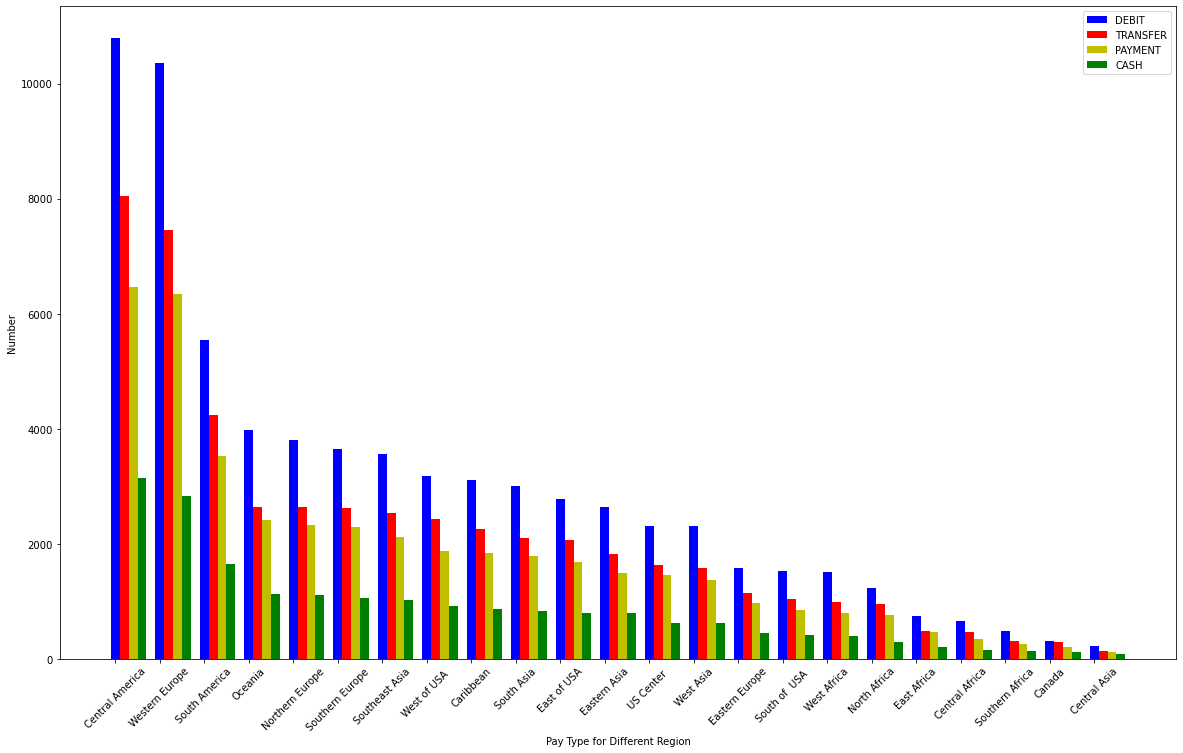

In [99]:
import numpy as np
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(20,12))

# 由于有四个支付类型，再加上一个区域之间的间隔，就是5个内容，因此平均下来宽度是0.2
# 其实这里有个bug,每种支付类型中的地区排序不一样的话，就错位了，


type1_region = type1['Order Region'].value_counts() # 得到keys为region,values为该region该支付类型数量
region_num = len(type1_region.keys())
bar_width = 0.2
index= np.arange(region_num)    #######list(range(region))
count = type1_region.values
plt.bar(index+bar_width*0, count, bar_width,color='b',label='DEBIT')

type2_region = type2['Order Region'].value_counts() # 得到keys为region,values为该region该支付类型数量
region = len(type2_region.keys())
count = type2_region.values
plt.bar(index+bar_width*1, count, bar_width,color='r',label='TRANSFER')

type3_region = type3['Order Region'].value_counts() # 得到keys为region,values为该region该支付类型数量
region = len(type3_region.keys())
count = type3_region.values
plt.bar(index+bar_width*2, count, bar_width,color='y',label='PAYMENT')

type4_region = type4['Order Region'].value_counts() # 得到keys为region,values为该region该支付类型数量
region = len(type4_region.keys())
count = type4_region.values
plt.bar(index+bar_width*3, count, bar_width, color='g', label='CASH')

#plt.bar(index+bar_width*4, )

plt.xticks(index,list(type1_region.keys()),rotation=45)

plt.xlabel('Pay Type for Different Region')
plt.ylabel('Number')
plt.legend()
plt.show()

### 这样太整齐了。。。

### 果然，Bug实现了

In [100]:
region_stat = pd.DataFrame([type1_region.keys(),type2_region.keys(),type3_region.keys(),type4_region.keys()],
                          index=['DEBIT', 'TRANSFER', 'PAYMENT','CASH'])
region_stat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
DEBIT,Central America,Western Europe,South America,Oceania,Northern Europe,Southern Europe,Southeast Asia,West of USA,Caribbean,South Asia,East of USA,Eastern Asia,US Center,West Asia,Eastern Europe,South of USA,West Africa,North Africa,East Africa,Central Africa,Southern Africa,Canada,Central Asia
TRANSFER,Central America,Western Europe,South America,Northern Europe,Oceania,Southeast Asia,Southern Europe,Caribbean,West of USA,South Asia,Eastern Asia,East of USA,West Asia,US Center,South of USA,Eastern Europe,West Africa,North Africa,East Africa,Central Africa,Canada,Southern Africa,Central Asia
PAYMENT,Western Europe,Central America,South America,Oceania,Southeast Asia,Northern Europe,Southern Europe,Caribbean,South Asia,Eastern Asia,West of USA,East of USA,West Asia,US Center,South of USA,Eastern Europe,West Africa,North Africa,East Africa,Central Africa,Southern Africa,Canada,Central Asia
CASH,Central America,Western Europe,South America,Southern Europe,Oceania,Northern Europe,Southeast Asia,Caribbean,West of USA,East of USA,Eastern Asia,South Asia,West Asia,US Center,Eastern Europe,South of USA,West Africa,North Africa,Central Africa,East Africa,Canada,Southern Africa,Central Asia


#### 每种支付方式的地区排列都是不同的

In [101]:
### 那怎么改？？？

### sns.countplot

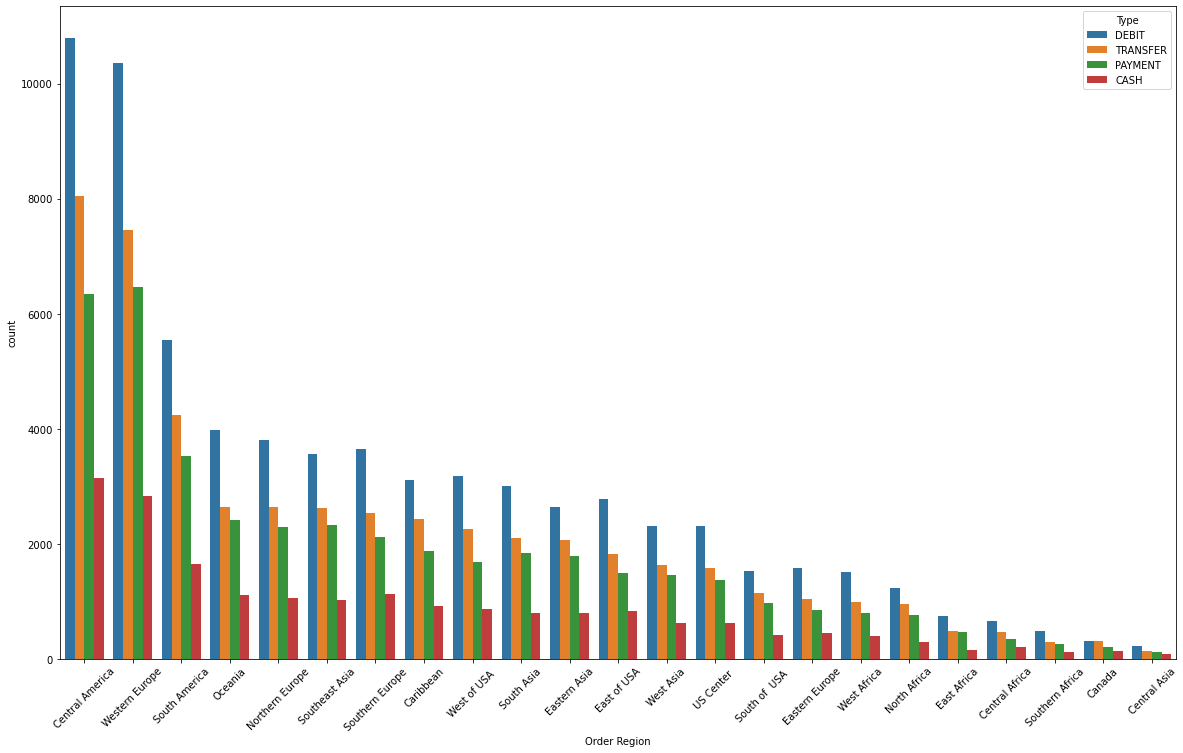

In [102]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(20,12))
sns.countplot(x='Order Region', 
              hue='Type',
              data=data,
              order=data['Order Region'].value_counts().keys(),      # order 排序，
              hue_order=data['Type'].value_counts().keys())          # hue_order 排序
plt.xticks(rotation='45')
plt.show()

### 分析：
* 在Central America地区交易次数最多，有钱！
* 而DEBIT是所有地区中使用最多的支付方式，现金最少
* 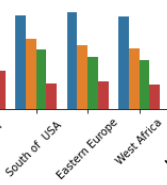
* 分布差不多


#### 负收益探索

In [103]:
# 收益为负
loss = data[data['Benefit per order'] < 0]
loss.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,Customer Segment,Customer State,Customer Street,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Order Item Discount,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Sales,Order Profit Per Order,Order Region,Order State,Order Status,Product Name,Product Price,shipping date (DateOrders),Shipping Mode,Customer FullName,order_year,order_month,order_week_day,order_hour,order_month_year,R_Value
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,Irene,19492,Luna,Consumer,PR,2679 Rustic Loop,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,2018-01-13 12:27:00,75939,16.389999,0.05,-0.80,1,327.75,-249.089996,South Asia,Rajastán,PENDING,Smart watch,327.75,2018-01-18 12:27:00,Standard Class,IreneLuna,2018,1,5,12,2018-01,18
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,Gillian,19491,Maldonado,Consumer,CA,8510 Round Bear Gate,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,2018-01-13 12:06:00,75938,18.030001,0.06,-0.80,1,327.75,-247.779999,South Asia,Rajastán,CLOSED,Smart watch,327.75,2018-01-17 12:06:00,Standard Class,GillianMaldonado,2018,1,5,12,2018-01,18
15,DEBIT,2,1,-259.579987,324.470001,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,Sade,19478,Lancaster,Corporate,PR,257 Harvest Close,2,Fitness,18.284050,-66.037056,Pacific Asia,Sangli,India,2018-01-13 07:33:00,75925,3.280000,0.01,-0.80,1,327.75,-259.579987,South Asia,Maharashtra,COMPLETE,Smart watch,327.75,2018-01-15 07:33:00,First Class,SadeLancaster,2018,1,5,7,2018-01,18
16,PAYMENT,5,2,-246.360001,321.200012,Late delivery,1,73,Sporting Goods,Canovanas,Puerto Rico,Brynne,19477,Giles,Corporate,PR,7342 Hazy Beacon Park,2,Fitness,18.395790,-65.872887,Pacific Asia,Seúl,Corea del Sur,2018-01-13 07:12:00,75924,6.560000,0.02,-0.77,1,327.75,-246.360001,Eastern Asia,Seúl,PENDING_PAYMENT,Smart watch,327.75,2018-01-18 07:12:00,Second Class,BrynneGiles,2018,1,5,7,2018-01,18
28,DEBIT,3,4,-17.139999,272.029999,Advance shipping,0,73,Sporting Goods,Roseville,EE. UU.,Evelyn,19465,Kelly,Corporate,MI,3931 Gentle Ramp,2,Fitness,41.868862,-84.573654,Pacific Asia,Guilin,China,2018-01-13 03:00:00,75912,55.720001,0.17,-0.06,1,327.75,-17.139999,Eastern Asia,Guangxi,COMPLETE,Smart watch,327.75,2018-01-16 03:00:00,Standard Class,EvelynKelly,2018,1,5,3,2018-01,18


In [104]:
# Top10的负收益类别？

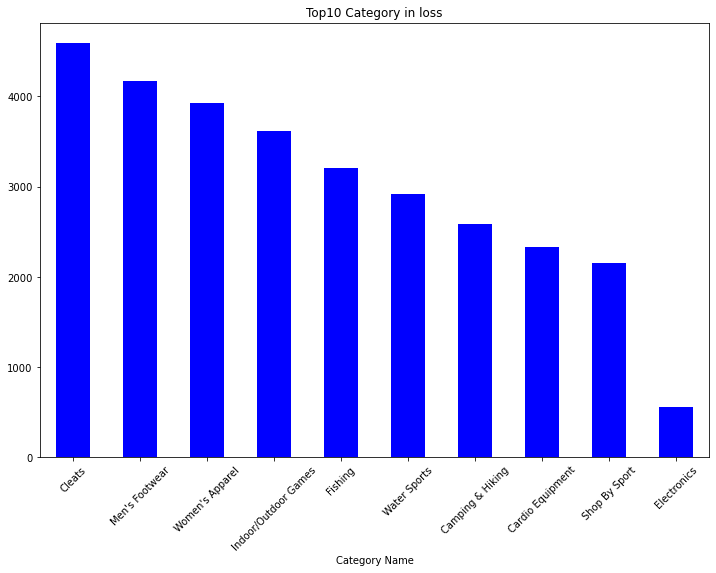

In [105]:
# 类别
loss_top10_category = loss['Category Name'].value_counts().nlargest(10)
loss_top10_category.plot.bar(figsize=(12,8), color='blue', title='Top10 Category in loss')
plt.xticks(np.arange(10), loss_top10_category.keys(), rotation=45)
plt.xlabel('Category Name')
plt.show()

* Cleats是最容易出现负收益的产品类型

那金额呢，哪个产品损失的总金额更多

In [106]:
loss_amount_category = loss.groupby('Category Name')['Sales'].sum().nlargest(10)
loss_amount_category

Category Name
Fishing                 1.283536e+06
Cleats                  8.231231e+05
Camping & Hiking        7.769482e+05
Cardio Equipment        6.912014e+05
Water Sports            5.859708e+05
Women's Apparel         5.834000e+05
Indoor/Outdoor Games    5.463314e+05
Men's Footwear          5.419283e+05
Shop By Sport           2.606566e+05
Computers               1.095000e+05
Name: Sales, dtype: float64

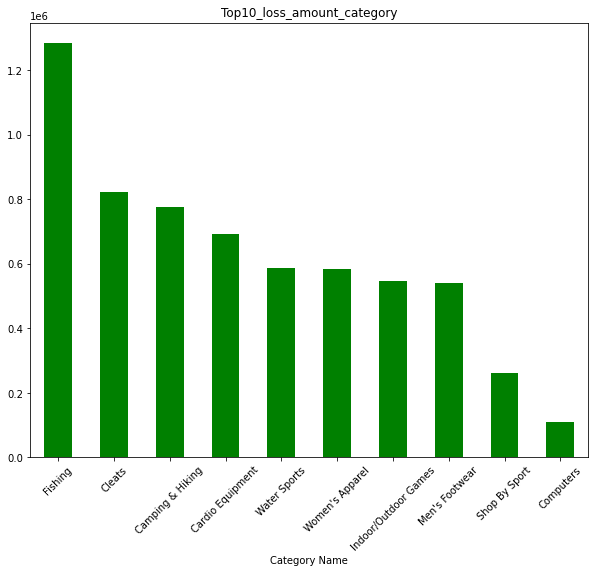

In [107]:
loss_amount_category.plot.bar(figsize=(10,8), color='green', title='Top10_loss_amount_category')
plt.xticks(rotation=45)
plt.show()

* 虽然Fishing负收益订单少，但损失的金额多呀，-->单价高！！！

In [108]:
# 显示Top10的负收益地区，负收益订单最多的地区

 这只是负收益订单笔数

In [109]:
loss_top10_region = loss['Order Region'].value_counts().nlargest(10)
loss_top10_region

Central America    5268
Western Europe     5104
South America      2754
Oceania            1944
Northern Europe    1809
Southeast Asia     1790
Southern Europe    1734
Caribbean          1566
West of USA        1511
South Asia         1469
Name: Order Region, dtype: int64

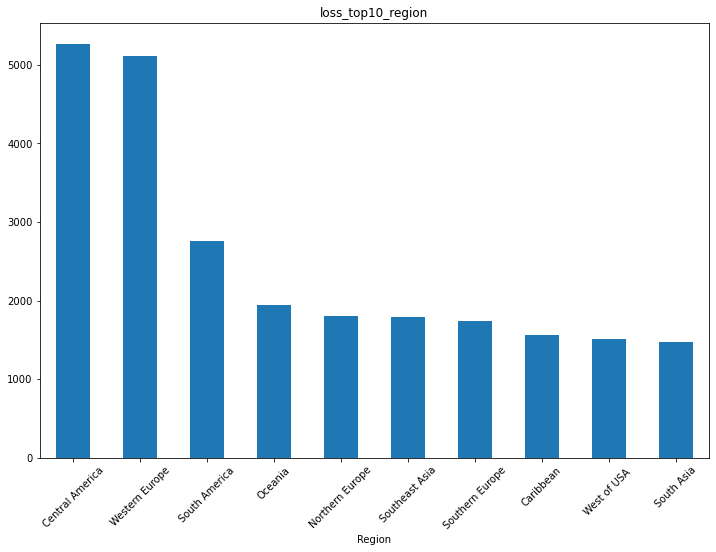

In [110]:
loss_top10_region.plot.bar(figsize=(12,8), title='loss_top10_region')
plt.xticks(np.arange(10), loss_top10_region.keys(), rotation=45)
plt.xlabel('Region')
plt.show()

In [111]:
# 总损失
loss.Sales.sum()

6870172.041295439

In [112]:
loss['Benefit per order'].sum()

-3883547.345768667

In [113]:
# 对于每个地区总损失的排序呢？钱重要嘛，不是订单数

 负收益订单额度

In [114]:
loss_amount_region = loss.groupby('Order Region')['Sales'].sum().nlargest(10)
loss_amount_region

Order Region
Western Europe     1.120912e+06
Central America    1.049633e+06
South America      5.414282e+05
Northern Europe    4.023718e+05
Oceania            3.900111e+05
Southern Europe    3.764023e+05
Southeast Asia     3.519799e+05
Caribbean          3.075977e+05
South Asia         2.960052e+05
West of USA        2.951724e+05
Name: Sales, dtype: float64

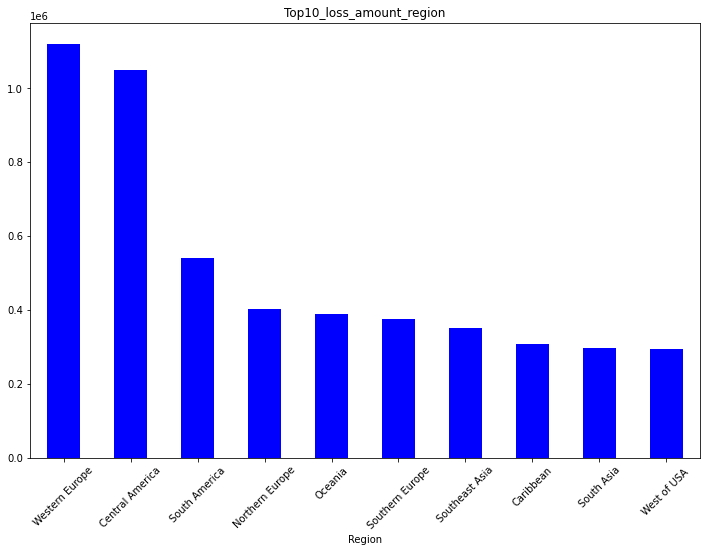

In [115]:
loss_amount_region.plot.bar(figsize=(12,8), color='b', title='Top10_loss_amount_region')
plt.xticks(np.arange(10), loss_amount_region.keys(), rotation=45)
plt.xlabel('Region')
plt.show()

In [116]:
# 交易类型

In [117]:
data['Order Status'].value_counts()

COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: Order Status, dtype: int64

In [118]:
# 负收益 欺诈交易 哪种支付方式

In [119]:
loss[loss['Order Status'] == 'SUSPECTED_FRAUD']['Type'].value_counts()

TRANSFER    793
Name: Type, dtype: int64

In [120]:
data[data['Order Status'] == 'SUSPECTED_FRAUD']['Type'].value_counts()

TRANSFER    4062
Name: Type, dtype: int64

#### 负收益，欺诈交易的唯一赞助商：Transfer

In [121]:
# 不同地区的欺诈交易情况

In [122]:
loss_suspect_region = loss[loss['Order Status'] == 'SUSPECTED_FRAUD']['Order Region'].value_counts().nlargest(10)
loss_suspect_region

Western Europe     140
Central America    117
South America       62
Southern Europe     53
Oceania             51
West of USA         50
Caribbean           43
Southeast Asia      34
Northern Europe     32
West Asia           31
Name: Order Region, dtype: int64

In [123]:
# loss_suspect_region = data[data['Order Status'] == 'SUSPECTED_FRAUD']['Order Region'].value_counts().nlargest(10)
# loss_suspect_region

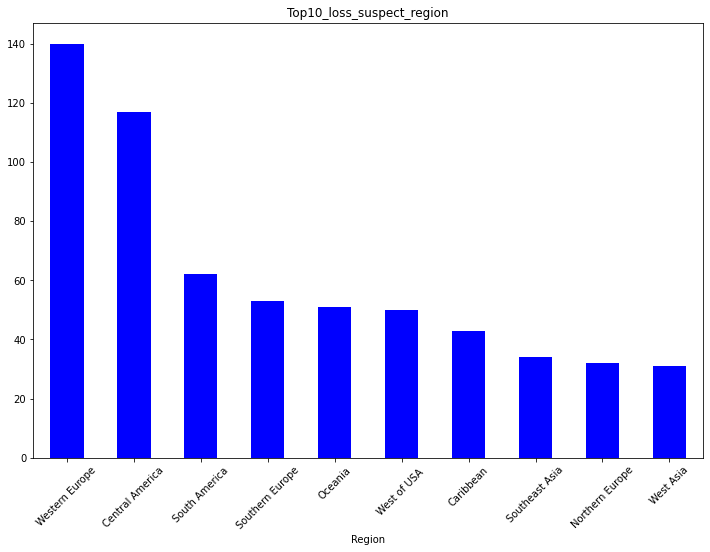

In [124]:
loss_suspect_region.plot.bar(figsize=(12,8), color='b', title='Top10_loss_suspect_region')
plt.xticks(np.arange(10), loss_suspect_region.keys(), rotation=45)
plt.xlabel('Region')
plt.show()

### 是否只有负收益的才存在欺诈呢？

In [125]:
fraud_benefit = data[data['Order Status'] == 'SUSPECTED_FRAUD']['Benefit per order']
print('{}笔欺诈订单中，存在{}笔负收益'.format(fraud_benefit.shape[0], (fraud_benefit<0).sum()))

4062笔欺诈订单中，存在793笔负收益


In [126]:
# 欺诈交易前十的商品类别
# 由于...地区欺诈交易最多，因此在一个商品类别中用堆积条形图显示出。。。地区

Western Europe

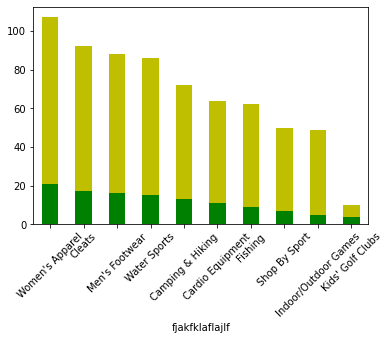

In [127]:
# 显示欺诈交易最多的
fraud = loss[loss['Order Status'] == 'SUSPECTED_FRAUD']
fraud_region = loss[(loss['Order Status'] == 'SUSPECTED_FRAUD') & (loss['Order Region']=='Western Europe')]
fraud['Category Name'].value_counts().nlargest(10).plot.bar(color='y')
fraud_region['Category Name'].value_counts().nlargest(10).plot.bar(color='g')
plt.xticks(rotation=45)
plt.xlabel('fjakfklaflajlf')
plt.show()

In [128]:
# 探索Top10 风险客户

In [129]:
# 根据用户名聚合，计算负收益中，Benefit per order
abs(loss.groupby('Customer FullName')['Benefit per order'].sum()).nlargest(10)

Customer FullName
MarySmith         492040.119906
JohnSmith          16329.909922
RobertSmith        15096.430089
JamesSmith         14078.999984
JenniferSmith      12314.469988
DavidSmith         11920.599983
AndrewSmith        11862.719886
ElizabethSmith     11587.040039
WilliamSmith       10861.869961
SamanthaSmith       8549.610013
Name: Benefit per order, dtype: float64

In [130]:
# 根据用户名聚合，计算负收益中，他们的Sales
loss.groupby('Customer FullName')['Sales'].sum().nlargest(10)

Customer FullName
MarySmith         880883.107128
RobertSmith        28124.980511
JohnSmith          25733.010449
JamesSmith         24699.390564
DavidSmith         23289.060406
ElizabethSmith     19565.670380
WilliamSmith       18383.150396
JenniferSmith      17990.710274
AndrewSmith        17918.060425
MichaelSmith       17289.050339
Name: Sales, dtype: float64

* Smith好名字

In [133]:
data.drop(columns='R_Value', inplace=True)

In [134]:
import pickle
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)